# Normalize Operator

This shows you how to use the `Normalize` operator.

## Introduction
Normalization is the process of shifting and scaling the data values to match the desired distribution. It calculates the mean $\mu$ and the standard deviation $\sigma$ and modifies the data as follows:

$$Y_i = \frac{X_i - \mu}{\sigma}$$

There are more advanced features in `Normalize` that will be explained later in this documentation.

## Using the `Normalize` Operator

We need some boilerplate code to import DALI and some other useful libraries and to visualize the results.

In [1]:
from nvidia.dali.pipeline import Pipeline
import math
import nvidia.dali.ops as ops  
import nvidia.dali.fn as fn          
import nvidia.dali.types as types
import nvidia.dali.backend as backend

batch_size = 10
image_filename = "../data/images"

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def display(outputs, idx, columns = 2, captions = None):
    rows = int(math.ceil(len(outputs) / columns))
    fig = plt.figure()
    fig.set_size_inches(16, 6 * rows)
    gs = gridspec.GridSpec(rows, columns)
    row = 0
    col = 0
    for i, out in enumerate(outputs):
        if isinstance(out, backend.TensorListGPU):
            out = out.as_cpu()
        plt.subplot(gs[i])
        plt.axis("off")
        if captions is not None:
            plt.title(captions[i])
        plt.imshow(out.at(idx));
        
def show(pipe, idx, columns = 2, captions = None):
    pipe.build()
    display(pipe.run(), idx, columns, captions)


### A Simple Pipeline

Create a simple pipeline that just loads some images and normalizes them, and treats the image data as a flat array that contains `3*W*H` numbers (3 for RGB channels).

In [2]:
pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=0)
with pipe:
    jpegs, _ = fn.readers.file(file_root=image_filename)
    images = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)
    norm = fn.normalize(images)

    pipe.set_outputs(images, norm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


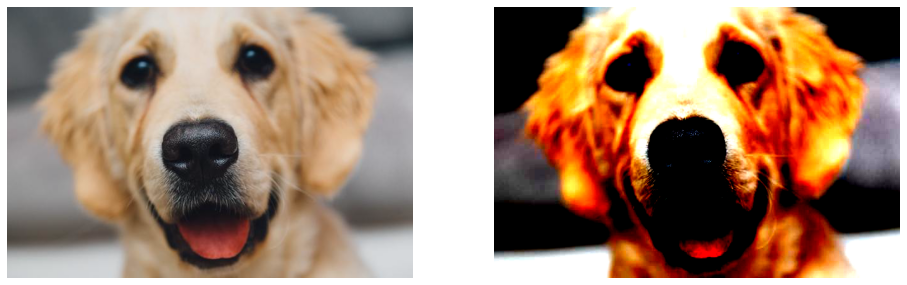

In [3]:
show(pipe, 1)

## Adjusting Output Dynamic Range
As you can see in the example above, the image intensity values have been scaled and shifted, with many pixels forced below 0, and displayed as black.
You might want this result in many use cases, but if the output type has limited dynamic range (for example `uint8`), you might want to map the mean and standard deviation to values that more effectively use that limited range of values.
For this purpose, `Normalize` offers two scalar arguments, `shift` and `scale`. Now the normalization formula becomes:

$$Y_i = \frac{X_i - \mu}{\sigma} \cdot {scale} + {shift}$$

Modify the pipeline to produce `uint8` output with the mean mapped to 128 and standard deviation to 64, which allows values in the $\mu \pm 2\sigma$ range to be correctly represented in the output.

In [4]:
pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=0)
with pipe:
    jpegs, _ = fn.readers.file(file_root=image_filename)
    images = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)
    norm = fn.normalize(images, scale=64, shift=128, dtype=types.UINT8)

    pipe.set_outputs(images, norm)

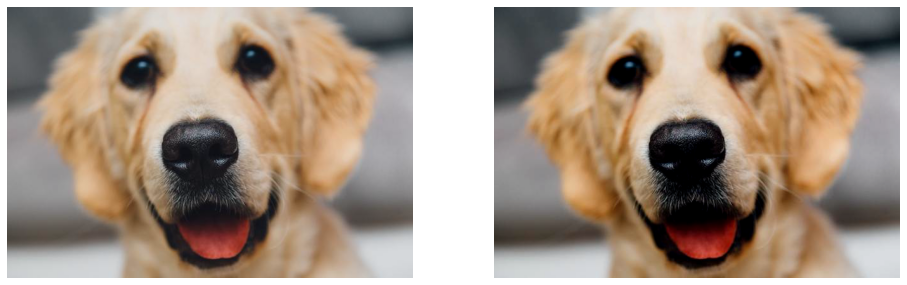

In [5]:
show(pipe, 1)

### Directional Reductions
For multidimensional data, it might be useful to calculate the mean and standard deviation for only a subset of the dimensions. For example, the dimensions might correspond to height (0), width (1) and color channels (2) of an image. Reducing the 0, 1 (height, width) dimensions will produce a separate mean and standard deviation for each channel.
`Normalize` supports two arguments to specify directions:

 - `axes` - a tuple of dimension indices, with 0 being outermost.
 - `axis_names` - axis symbols that were looked up in the input layout.

The following example normalizes the data along WC, H, WH and C. 

In [6]:
pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=0)
with pipe:
    jpegs, _ = fn.readers.file(file_root=image_filename)
    images = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)
    normwc  = fn.normalize(images, axes = (1, 2), scale=64, shift=128, dtype=types.UINT8)
    normh  = fn.normalize(images, axis_names = "H", scale=64, shift=128, dtype=types.UINT8)
    normhw = fn.normalize(images, axis_names = "HW", scale=64, shift=128, dtype=types.UINT8)
    normc  = fn.normalize(images, axes = (2,), scale=64, shift=128, dtype=types.UINT8)

    pipe.set_outputs(images, normwc, normh, normhw, normc)

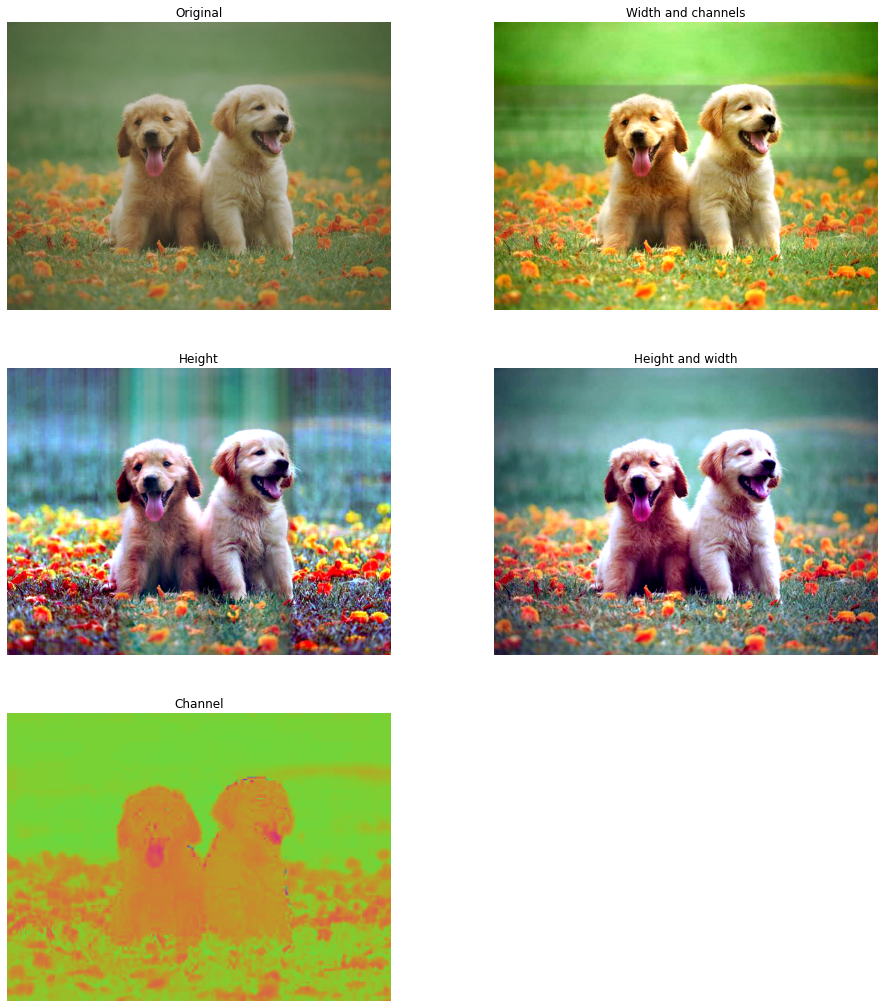

In [7]:
titles = ["Original", "Width and channels", "Height", "Height and width", "Channel"]
show(pipe, 9, captions=titles)

## Externally Provided Parameters
By default, `Normalize` calculates the mean and standard deviation internally. However, these values can be provided externally via the `mean` and `stddev` arguments, and can be scalar values or inputs. When providing `mean` or `stddev` values as inputs, the directions of reduction can be inferred from parameter's shape. If the `mean` and `stddev` values are inputs, they must have the same shapes.

In [8]:
pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=0)
with pipe:
    jpegs, _ = fn.readers.file(file_root=image_filename)
    images = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)
    norm_mean = fn.normalize(
        images, mean=64, axis_names="HW", scale=64, shift=128, dtype=types.UINT8)
    norm_stddev = fn.normalize(
        images, stddev=200, axis_names="HW", scale = 64, shift=128, dtype=types.UINT8)

    pipe.set_outputs(images, norm_mean, norm_stddev)

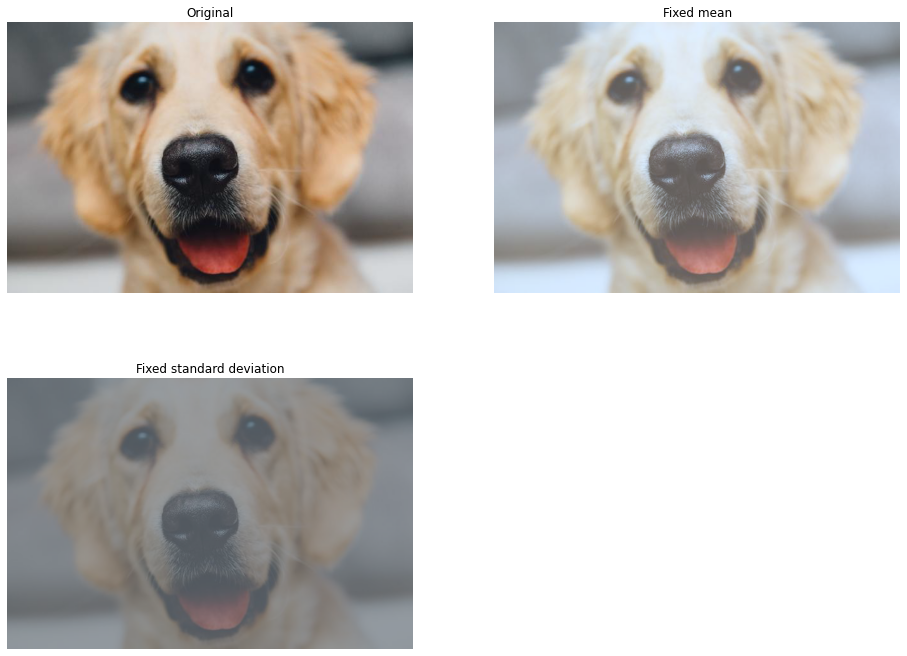

In [9]:
show(pipe, 1, captions=["Original", "Fixed mean", "Fixed standard deviation"])

## Batch Normalization
`Normalize` can calculate the mean and standard deviation for the entire batch instead of on a per-item basis. You can enable this behavior by setting the `batch` argument to `True`. Batch normalization demands that the extent of the non-reduced dimensions matches all samples in the batch. For example, because channels are normalized separately, the pipeline below expects that all images have three channels.

In [10]:
pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=0)
with pipe:
    jpegs, _ = fn.readers.file(file_root=image_filename)
    images = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)
    norm_sample = fn.normalize(
        images, batch=False, axis_names="HW", scale=64, shift=128, dtype=types.UINT8)
    norm_batch = fn.normalize(
        images, batch=True, axis_names="HW", scale = 64, shift=128, dtype=types.UINT8)

    pipe.set_outputs(images, norm_sample, norm_batch)

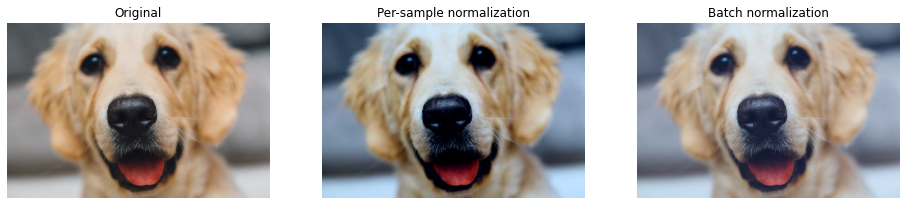

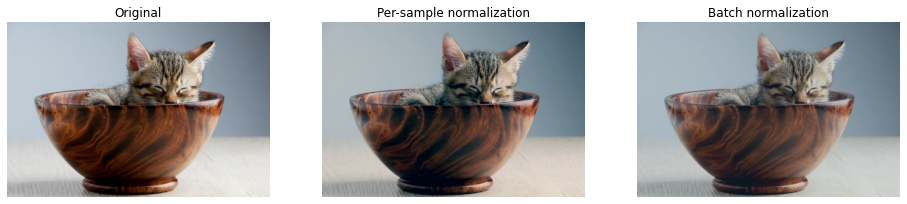

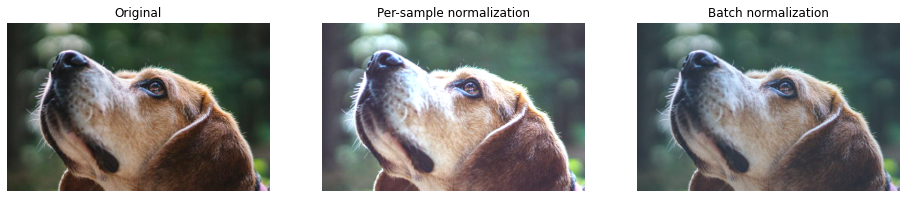

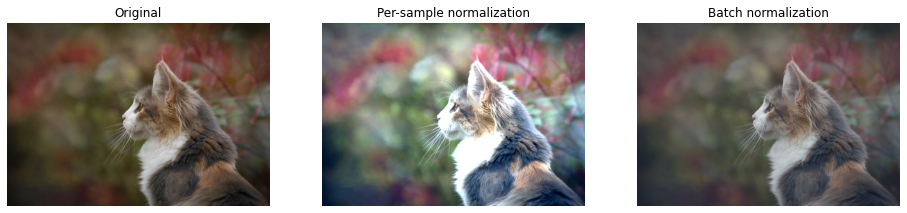

In [11]:
show(pipe, 1, columns=3, captions=["Original", "Per-sample normalization", "Batch normalization"])
show(pipe, 4, columns=3, captions=["Original", "Per-sample normalization", "Batch normalization"])
show(pipe, 7, columns=3, captions=["Original", "Per-sample normalization", "Batch normalization"])
show(pipe, 9, columns=3, captions=["Original", "Per-sample normalization", "Batch normalization"])